# AMiMA (Anki Mind Map)
# This work is licensed under GNU GPL v3, see the related LICENSE file for more

Released under the GNU General Public License v3.
Copyright (C) - 2021 - user "thiswillbeyourgithub" of the website "github".
This file is part of AMiMA (anki mind map). Plotting your anki flashcards 
by meaning.

AMiMA is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

AMiMA is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with AMiMA.  If not, see <https://www.gnu.org/licenses/>.
for more information or to get the latest version go to :
https://github.com/thiswillbeyourgithub/AMiMA_anki_mind_map/

# User settings

In [3]:
# path setup :
username = "USERNAME"
profile_name = "Main"
anki_location = f"/home/{username}/.local/share/Anki2/{profile_name}/collection.anki2"

# options :
include_numbers = True  # default True, otherwise it removes all numbers from the text of cards
adj_ratio = 10  # default 10, means that sfld will be copied until it represent 3 times more numbers than the rest of flds, so acts like a way to prioritize the sort field
number_of_clusters = 200  # this is the argument given to kmeans for the clustering
stop_words_language = ""

# decks and tags keywords that should be excluded :
to_remove = [""]  # default [""] (so it has to be a list)
# Please note that much of the code is briefly explained in the README

# Initialization

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import unidecode
import sqlite3
import os
import re
from tqdm import tqdm
from nltk.corpus import stopwords
import transformers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import plotly.express as px
import umap.umap_

# Loading anki's db

In [5]:
db_loc = "/tmp/anki.db"  # location of the temporary db, to avoid issues with locked db
os.system(f"rm {db_loc}")
os.system(f"\cp --remove-destination {anki_location} {db_loc}")

def get_tb_list(db_loc):
    "func that fetches the list of tables from the db"
    conn = sqlite3.connect(db_loc)
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def get_all_tb(db_loc):
    "func that fetches the select table from the db"
    tb_todo = get_tb_list(db_loc)
    #print(tb_todo)
    all_tb = []
    conn = sqlite3.connect(db_loc)
    for i in tb_todo["name"] :
        query = f"SELECT * FROM {i};"
        try :
            new = pd.read_sql_query(query, conn)
        except :
            print(f"ERROR when processing field : {i}")
            print("(The error about the field \"tag\" doesn't matter)")
        all_tb.append(new)
    conn.close()
    return all_tb


tb = get_all_tb(db_loc)
anki = tb[1].copy().set_index("id")

# fetching the deck name :
deck_id_name = tb[-1].copy().set_index("id")
cardid_did = tb[2].copy().set_index("nid")


def deck_namer(card_id, card_id_did, deck_id_name):
    did = card_id_did.loc[card_id]['did']
    name = deck_id_name.loc[did]["name"]
    name = re.sub('\u001F',"::", str(name)) # removes \x1F
    return name


# fetching the notetype :
notetype_id_name = tb[-2].copy().set_index("id")
cardid_mid = tb[1].copy().set_index("id")


def notetype_namer(card_id, card_id_mid, notetype_id_name):
    mid = card_id_mid.loc[card_id]['mid']
    name = notetype_id_name.loc[mid]["name"]
    return name


deck_id_name.sort_index();
cardid_did.sort_index();
notetype_id_name.sort_index();
cardid_mid.sort_index();

anki["deck_name"] = [deck_namer(n, cardid_did, deck_id_name) for n in tqdm(anki.index)]
anki["notetype"] = [notetype_namer(n, cardid_mid, notetype_id_name) for n in tqdm(anki.index)]

anki.drop(columns=["guid", "mid", "usn", "mod", "csum", "flags", "data"], inplace=True)
anki.sort_index();

  1%|          | 337/30404 [00:00<00:08, 3361.47it/s]

ERROR when processing field : tags
(The error about the field "tag" doesn't matter)


100%|██████████| 30404/30404 [00:06<00:00, 4687.75it/s]


## Removing specific tags and decks

In [7]:
print(f"Before cleanup : {len(anki.index)}")

anki["tags"] = anki["tags"].str.lower()
anki["deck_name"] = anki["deck_name"].str.lower()

if to_remove != [""]:
    for i in tqdm(to_remove) :
        anki = anki[ -(anki["deck_name"].str.contains(i)) ]
        anki = anki[ -(anki["tags"].str.contains(i)) ]
    
print(f"After deck and tags removal : {len(anki.index)}")

Before cleanup : 30404
After deck and tags removal : 30404


In [8]:
to_remove ==[""]

True

## Removing duplicate notes

In [9]:
anki.drop_duplicates("sfld", keep="first", inplace=True, ignore_index=False)
anki.drop_duplicates("flds", keep="first", inplace=True, ignore_index=False)
print(f"After removing duplicates : {len(anki.index)}")

After removing duplicates : 25322


## Removing image occlusion note ID

In [10]:
for i in tqdm(anki.index):
    if "cclusion" in str(anki.loc[i]["notetype"]) :
        content = anki.loc[i]["flds"]
        content = re.sub("^[a-zA-Z0-9-]+\u001F", "", content)
        anki.loc[i]["flds"] = content

100%|██████████| 25322/25322 [00:02<00:00, 12550.47it/s]


## Tokenization

In [11]:
stops = stopwords.words('english') + stopwords.words('french')
stops = sorted(list(set(stops)))
for i in tqdm(["si", "est", "a", "does", "do", "have", "is"]):
    # removes a few stop words as I think they are important
    try : stops.remove(i)
    except : pass

100%|██████████| 7/7 [00:00<00:00, 120328.39it/s]


In [12]:
if include_numbers is True:
    alphaNumeric = re.compile("[a-z0-9]{1,25}")
if include_numbers is False:
    alphaNumeric = re.compile("[a-z]{1,25}")

def text_processor(content) :
    content = str(content).lower()
    
    content = re.sub('[a-zA-Z0-9-]+\....'," ", content)  # removes media
    content = re.sub('\\n|<div>|</div>|<br>|<span>|</span>|<li>|</li>|<ul>|</ul>'," ", content) # removes newline
    content = re.sub('\u001F'," ", content) # removes \x1F
    content = unidecode.unidecode(content)  # remove accents etc
       
    content = re.sub("<a href.*?</a>", " ", content) # removes links
    #content = re.sub("title=(\".*?\")", "> OCR \\1 <", content) # extract title of images (usually OCRed text) before html is removed
    content = re.sub("<.*?>", " ", content) # removes html tags
    
    content = re.sub("{{c\d+::|}}", "", content) # removes clozing
    content = re.sub("::|:|\?|\!|\+|-|'", " ", content) # part of clozing + punc + misc
    content = re.sub("&nbsp;", " ", content) # html spaces
    content = re.sub("/", " ", content) # replaces / by a space
    
    if include_numbers is True:  # removes all non letters or words
        content = re.sub("[^a-zA-Z ]", "", content)
    if include_numbers is False:
        content = re.sub("[^a-zA-Z0-9 ]", "", content)
        
    # stop words removal :
    content = [w for w in alphaNumeric.findall(content) if w not in stops]
    content = ' '.join(content).strip()
    return(content)

In [13]:
anki["sfld_pr"] = [text_processor(content) for content in tqdm(anki["sfld"])]
anki.sort_index();
anki["flds_pr"] = [text_processor(content) for content in tqdm(anki["flds"])]
anki.sort_index();

100%|██████████| 25322/25322 [00:04<00:00, 5442.61it/s]


## Re adjusting word counts
This step just repeats the sfld over and over until the number of words from sfld is twice the one from flds, this acts like a ponderation parameter

In [14]:
anki["after_adj"] = ""
for i in tqdm(anki.index):
    if not "cclusion" in anki.loc[i]["notetype"]:
        sfld = anki.loc[i]["sfld_pr"]
        if sfld != "":
            flds = anki.loc[i]["flds_pr"]
            n_sfld = len(str(sfld).split(" "))
            n_flds = len(str(flds).split(" ")) - n_sfld
            nb_to_rpt = adj_ratio*int(n_flds / n_sfld)
            anki.loc[i]["after_adj"] = str((sfld + " ")*nb_to_rpt + " " + flds).strip()

100%|██████████| 25322/25322 [00:06<00:00, 3734.64it/s]


In [15]:
anki.sort_index();

In [16]:
tokenizer2 = transformers.BertTokenizerFast.from_pretrained('bert-base-multilingual-uncased')

anki["all_tkns"] = [' '.join(tokenizer2.convert_ids_to_tokens(tokenizer2.encode(i, add_special_tokens=False, truncation=False))) for i in tqdm(anki["after_adj"])]

100%|██████████| 25322/25322 [00:03<00:00, 6729.09it/s]


# Dimensionnality reduction

In [22]:
tfidf = TfidfVectorizer(tokenizer=None)
tfs = tfidf.fit_transform(anki['all_tkns'])
tfs_reduced = TruncatedSVD(n_components=number_of_clusters, random_state=42).fit_transform(tfs)  # I really don't know how useful this is

## UMAP

In [23]:
umap_embed = umap.UMAP(n_jobs=-1, verbose=3, n_components=2, metric="euclidean", init="random", random_state=42, transform_seed=42, n_neighbors=5, min_dist=1, n_epochs=500, target_n_neighbors=number_of_clusters).fit_transform(tfs_reduced)

UMAP(dens_frac=0.0, dens_lambda=0.0, init='random', min_dist=1, n_epochs=500,
     n_neighbors=5, random_state=42, target_n_neighbors=200, verbose=3)
Construct fuzzy simplicial set
Wed Mar 24 13:59:05 2021 Finding Nearest Neighbors
Wed Mar 24 13:59:05 2021 Building RP forest with 13 trees
Wed Mar 24 13:59:06 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	Stopping threshold met -- exiting after 6 iterations
Wed Mar 24 13:59:06 2021 Finished Nearest Neighbor Search
Wed Mar 24 13:59:06 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Mar 24 13:59:36 2021 Finished embedding


# Clustering

In [24]:
kmeans = KMeans(n_clusters=number_of_clusters)
anki['cluster_kmeans_umap_embed'] = kmeans.fit_predict(umap_embed)

# Plotting

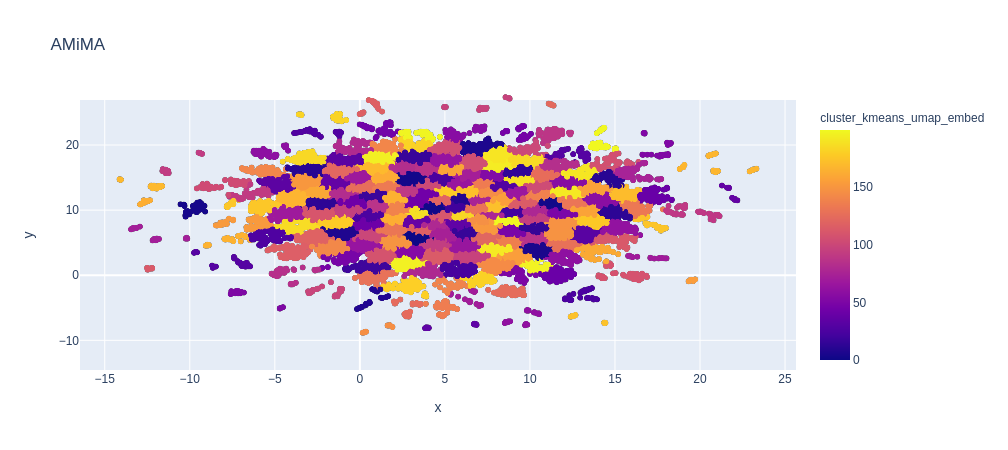

In [27]:
fig = px.scatter(anki,
                 title="AMiMA",
                 x=umap_embed[:,0],
                 y=umap_embed[:,1],
                 color=anki["cluster_kmeans_umap_embed"],
                 hover_data=["sfld_pr"])
fig.show()